# Starshade Fourier Model

## The Input:

Wish to create an optical model which takes as input a finite 2D star-planet scene and outputs an image that a CCD would realistically obtain

In [1]:
from IPython.display import Image

import numpy as np
import numpy.linalg as la
import math
import numpy.ma as ma
from matplotlib.colors import LogNorm
from astropy.io import fits
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure',titlesize=25)
plt.rc('lines',linewidth=2)

pc_to_meter = 3.08567782e16
au_to_meter = 149597870700.
focal_length_lens = 30
diameter_lens = 2.4 
dist_to_ss = 10*pc_to_meter
wavelength = 633e-9
roi = 120.*au_to_meter
angres = (4*633e-9)/(25)
#print (angres*10*pc_to_meter) # spatial resolution at 10 pc
telescope_diameter = 1.1
exo_pos = [0, au_to_meter, 0]
dist_ss_t = 63942090. #distance for hypergaussian function t_MH
dist_ss_t = 80000000.

Populating the interactive namespace from numpy and matplotlib


Let's look at a typical input scene:

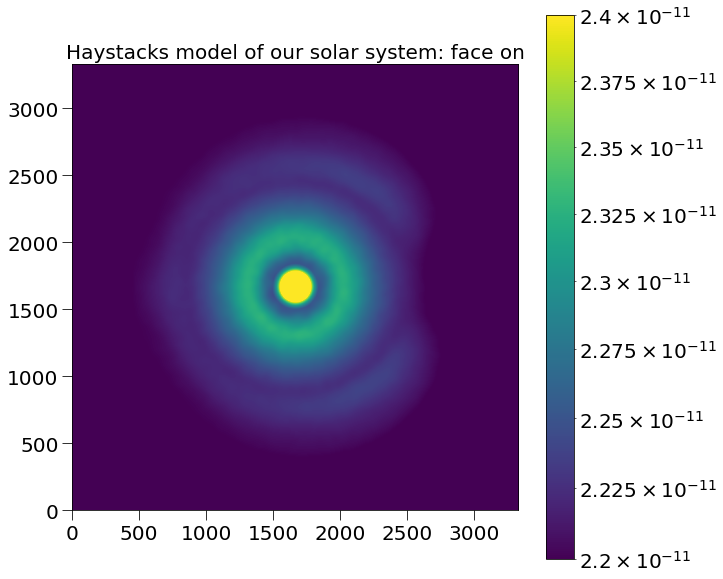

In [2]:
haystacks_file = 'modern_cube_zodi1inc0dist10_0.70-0.87um.fits'
haystacks = fits.open(haystacks_file)

cubehdr = haystacks[0].header
N_EXT = cubehdr['N_EXT'] 
dx = cubehdr['PIXSCALE'] #units are AU

_slice = haystacks[5].data
_wavel = haystacks[5].header['WAVEL'] # wavelength in micrometers
len_data = len(_slice[0])

plt.figure(figsize=(10,10))
from matplotlib.colors import LogNorm
plt.title('Haystacks model of our solar system: face on', fontsize=20)
plt.imshow(_slice,norm=LogNorm(vmin=2.2e-11,vmax=2.4e-11))
plt.colorbar()

In [3]:
print('Number of slices:', N_EXT, ', pixel size[AU]:', dx, ', N: ',len_data ,', wavelength[micrometers]:', _wavel)


Number of slices: 64 , pixel size[AU]: 0.03 , N:  3333 , wavelength[micrometers]: 0.711009


## General Fourier Model

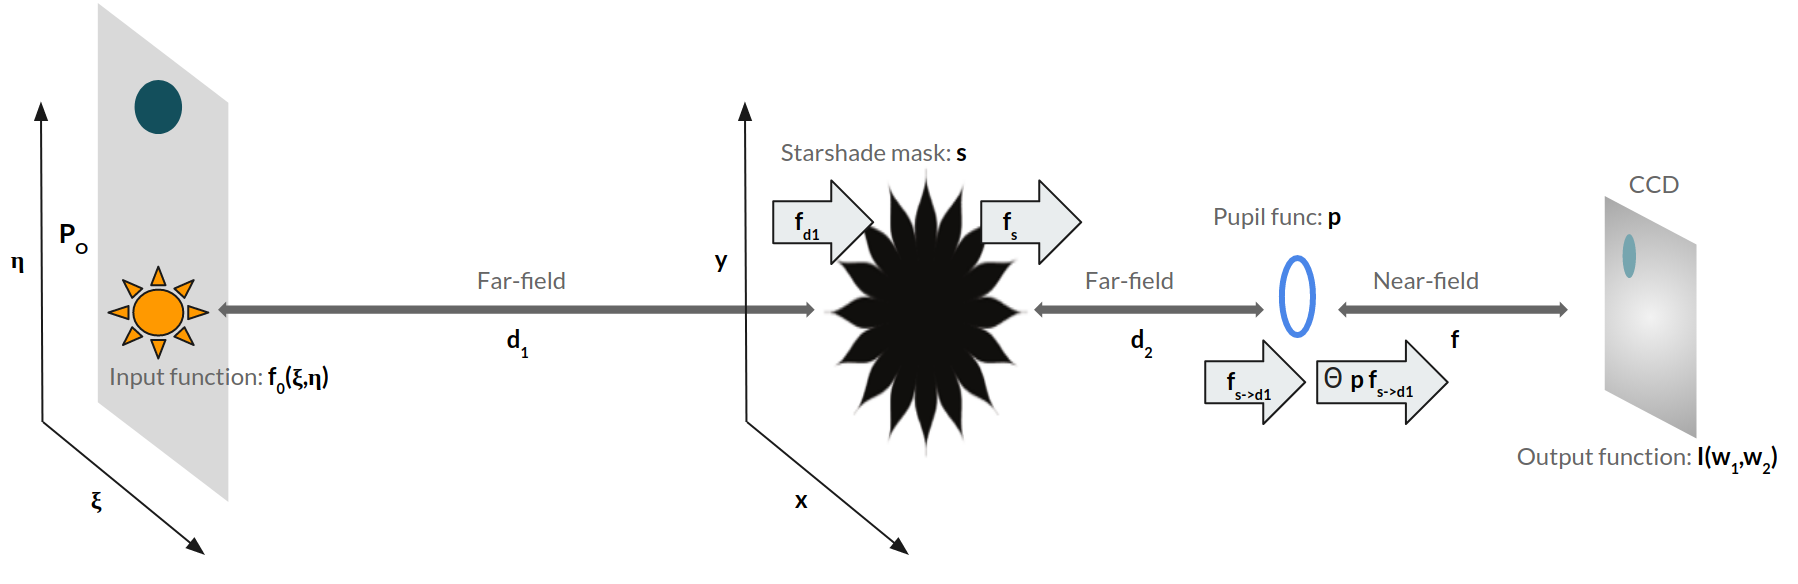

In [4]:
starshade_graphic = Image(filename='starshade-graphic.png')
starshade_graphic

Using Fourier optics we can describe the field in the focal plane by sequentially performing convolutions, Fourier transforms and masking operations:

The input scene is a function of $\lambda$, in other words $f_0[\xi, \eta,\lambda]$

We may independently propagate fields with different values of $\lambda$ and sum together the results to find the output. Therefore we henceforth consider $\lambda$ to be fixed. We will revisit this later.

   Our input is : $f_0[\xi, \eta]$

<font color='teal'>Discretization of the input scene should at least match the optical resolution (5 pixels per AU), however for realistic scene simulation we wish to include as much detail (and with as much spatial extent) as is computationally possible!</font>

$f_{d_1}$ is the result of far-field propagation of the input scene through free space
This field is masked by the starshade (a binary function which is 0 inside the occulter and 1 everywhere else), hence we obtain the field immediatly after starshade as: $f_s = s \cdot f_{d_1}$

The field incident on the telescope $f_{s \to {d_2}}$ is computed via convolving $f_s$ with the Fresnel impulse response $h_f(d_2)$:

$f_{s \to {d_2}} = f_s * h_f(d_2) = \mathcal{F}^{-1}(\mathcal{F}(f_{s}) \cdot H_f(d_2))$

We may treat the telescope as a thin lens and use Fresnel propagation (at the distance of the focal length) to calculate the field incident on the CCD.
We obtain this field as the Fraunhofer propagation of the product of $f_{s \to d_2}$ and a pupil function $p$:

$f_f [\hat{x}]= \mathcal{F}(f_{s \to {d_2}} \cdot p)[\frac{\hat{x}}{\lambda f}]$

An equivalent computation is given by:

$f_f [\hat{x}]= \{ (\mathcal{F}(f_{s}) \cdot H_f(d_2)) * \mathcal{F}(p) \}[\frac{\hat{x}} {\lambda f}]$


#### <font color='maroon'>Does structure make a difference: compute all at once or sequentially?</font>

## Point-Source Input Model

The idea is to treat every pixel from the input field as a point source with an associated amplitude (given by the pixel value) and offset (given by the pixel location).

$f_0[\hat{x}] = A\cdot \delta (\hat{x} - \hat{r})$


Let's simulate an input field consisting of two point sources. A central bright pixel (A=1.) and a dimmer pixel  (A=.1) at a distance of $1[AU]$ (33 pixels in Haystacks dimensions) from the centre.

$f_0[\xi, \eta] = \delta ([\xi, \eta]^T - [0, 0]^T) + .1 \delta ([\xi, \eta]^T - [1[AU], 0]^T)$


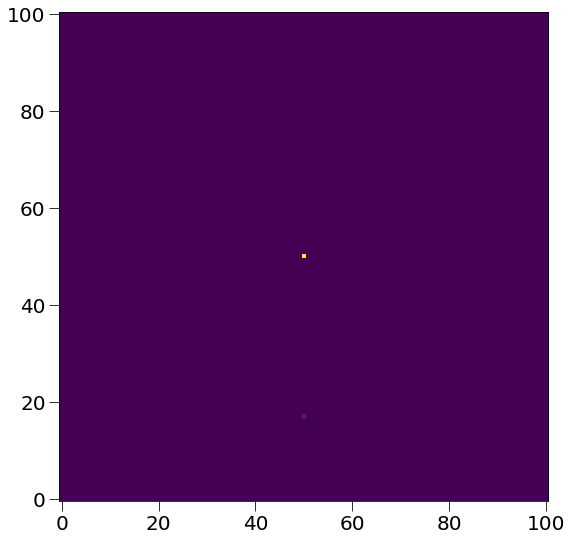

In [5]:
input_field = np.zeros((101,101))
input_field[50,50] = 1.
input_field[50-33, 50] = .1
plt.figure(figsize=(9,9))
plt.imshow(input_field)

Analytically the far-field propagation of a point source is known (expanding spherical waves become planar)!

The plane wave for a single point source is described by its wave-vector $k_{\xi, \eta}$ and amplitude of point source $A$.

The field at a distance $d_1$ is a linear combination of planar waves corresponding to each point source:

$f_{d_1} =  \exp{< k_{0,0}, [x,y,d_1]^T>} + .1\cdot \exp{< k_{0,1[AU]}, [x,y,d_1]^T>} $ 

<font color='teal'>Hencefort let's treat $d_1$ as the origin.</font>

In [6]:
def k_vector(x, y,  distance, wl):
    #returns k vector for a given pixel
    norm = (x**2 + y**2 + distance**2)**.5
    k = 2*np.pi/wl
    return np.array([-x*k/norm, -y*k/norm, distance*k/norm])

def plane_wave(A, r, k):
    return A*np.exp(1j* np.inner(k, r))

dist_au = 1.
k_exo = np.array([0, -np.sin((dist_au*au_to_meter/(10*pc_to_meter))), np.cos((dist_au*au_to_meter/(10*pc_to_meter)))])*2*np.pi/wavelength #k vector of incoming plane wave
k_star = np.array([0,0,1])*2*np.pi/wavelength

### Babinet's Principle

Since the plane wave has an infinite support, if we wish to numerically compute the field after starshade (at distance $d_2$ we would have to take the Fourier transform of an infinite field. Instead we may propagate the field past the starshade complement and subtract this from the free space propagation of the plane wave (which is just the plane wave at a distance $d_2$).

$f_{d_2}[x, y] = P[x, y, d_2] -  \mathcal{F}^{-1}(\mathcal{F}(f_{s'}) \cdot H_f(d_2))[x, y]$



/home/ielo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


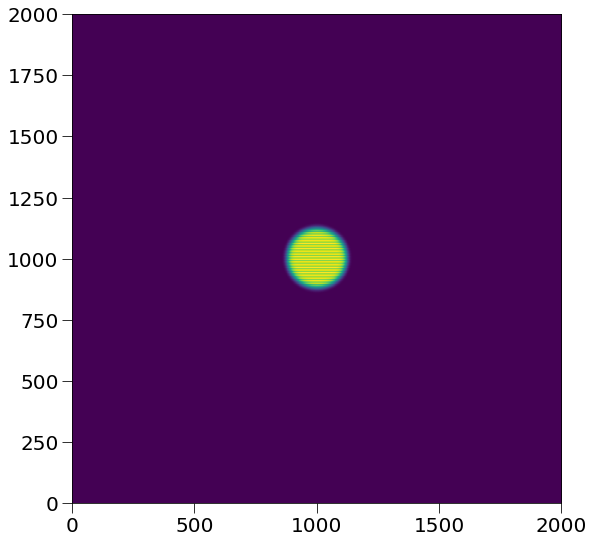

In [24]:
def t_MH(r, theta):
    a=b=12.5
    n=6.
    return np.abs((r<a)-1)*(1.-np.exp(-((r-a)/b)**n))

def cart_to_pol(x,y):
    r = (x**2 + y**2)**.5
    theta = (np.logical_and(r!=0, y>=0)*2 - 1) * np.arccos(x/r)
    return r, theta


xvals = np.linspace(-100,100,2001)
yvals = np.linspace(-100,100,2001)
xx, yy = np.meshgrid(xvals, yvals)

(r_, th) = cart_to_pol(xx,yy)
tA_complement = 1-t_MH(r_, th) 
#pupil_aperture = pupil_func(xx, yy, r=40)

field_after_ss = (plane_wave(1, np.array([xx,yy, 0]), k_star) +  plane_wave(.1, np.array([xx,yy,0]), k_exo) )* tA_complement 
plt.figure(figsize=(9,9))
plt.imshow(np.abs(field_after_ss))


In [25]:
def fresnel(p_x,p_y,image,propagation_distance=dist_ss_t,wavelength=633e-9):
    # convolving with the Fresnel impulse response via FFT multiplication
    fft = np.fft.fft2(image)

    pixelsize = p_x[1] - p_x[0]
    npixels = p_x.size
    freq_nyquist = 0.5/pixelsize
    freq_x = np.linspace(-1.0,1.0,npixels)*freq_nyquist

    pixelsize = p_y[1] - p_y[0]
    npixels = p_y.size
    freq_nyquist = 0.5/pixelsize
    freq_y = np.linspace(-1.0,1.0,npixels)*freq_nyquist

    freq_xy = np.array(np.meshgrid(freq_y,freq_x)) #create frequency grid
    
    k = 2 * np.pi / wavelength
    fft *= np.exp(1j * propagation_distance * k) * np.exp((-1j) * np.pi * wavelength * propagation_distance * np.fft.fftshift(freq_xy[0]**2 + freq_xy[1]**2) ) #p88 goodman

    ifft = np.fft.ifft2(fft)

    return ifft

def fraunhofer(x_coord,y_coord, amplitude,wavelength=633e-9):
    # coordinates in meters
    # returns propogated angle_x [rad], angle_y, complex_amplitude
    # fourier transform of aperture 
    # if aperture + lense, then gets evaluated at x*lambda*f where x is the input grid of the original amplitude

    F1 = np.fft.fft2(amplitude)
    F2 = np.fft.fftshift( F1 )

    # frequency for axis 1
    freq_nyquist = 0.5/(x_coord[1] - x_coord[0])
    freq_n = np.linspace(-1.0,1.0,len(x_coord))
    freq_x = freq_n * freq_nyquist
    freq_x *= wavelength

    # frequency for axis 2
    freq_nyquist = 0.5/(y_coord[1] - y_coord[0])
    freq_n = np.linspace(-1.0,1.0,len(y_coord))
    freq_y = freq_n * freq_nyquist
    freq_y *= wavelength 
    return freq_x, freq_y, F2


test_d_f = fresnel(xvals, yvals, field_after_ss)
field_free_prop = plane_wave(1, np.array([xx,yy, dist_ss_t]), k_star) +  plane_wave(1e-2, np.array([xx,yy, dist_ss_t]), k_exo)
field_at_telescope = field_free_prop - test_d_f

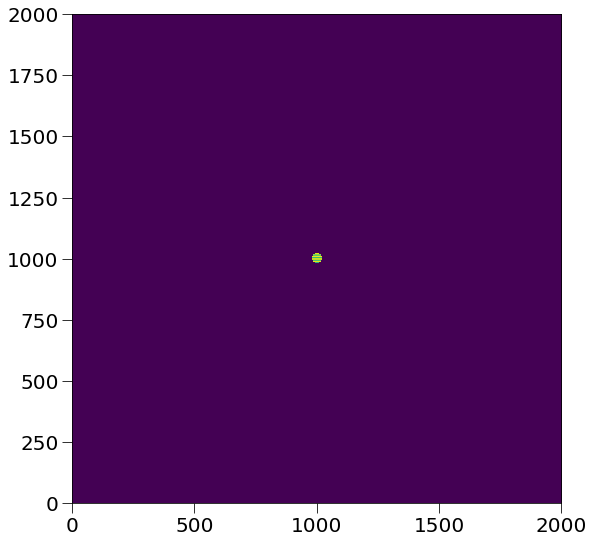

In [26]:
def pupil_func(x, y, r=3.):
    return ((x**2 + y**2)**.5 <= r)

lens_transmit = pupil_func(xx, yy, r=4.)
f_t = (field_free_prop - test_d_f)*lens_transmit
plt.figure(figsize=(9,9))
plt.imshow(np.abs(f_t))

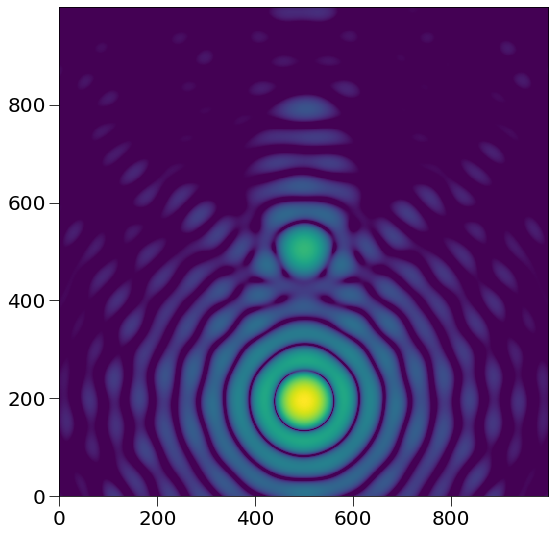

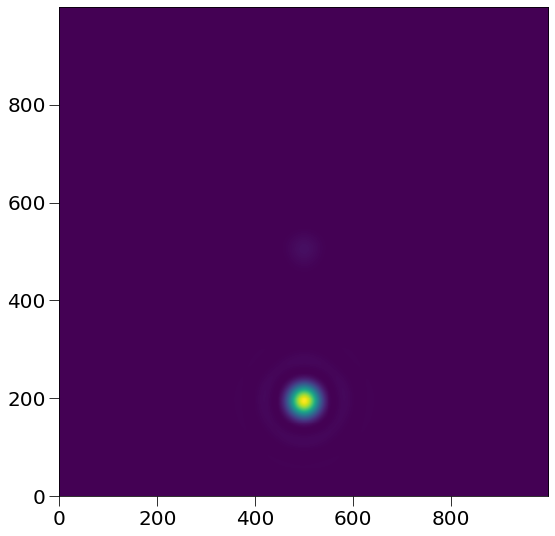

In [27]:
fx, fy, image_field_compl = fraunhofer(xvals, yvals, f_t)
plt.figure(figsize=(9,9))
#norm=LogNorm(vmin=2.2e-3,vmax=2.4e5)
max_int = np.max(np.abs(image_field_compl[500:1500, 500:1500])**2)
plt.imshow(np.abs(image_field_compl[500:1500, 500:1500])**2, norm=LogNorm(vmin=1e-2,vmax=max_int))
plt.figure(figsize=(9,9))
plt.imshow(np.abs(image_field_compl[500:1500, 500:1500])**2)


## Numerical Requirements for Realistic Simulation

### What are the sampling and dimensionality requirements at each plane?

Lets work backwards from the focal plane:

Image formed on $1000 \cdot 1000$ CCD grid with pixel length $\delta_{w} = 12 \mu m$

The field at the focal plane at CCD pixel locations $\hat{w}$ is found from the Fourier transform of the field incident on telescope masked by a pupil function:

$f_f [\hat{w}]= \mathcal{F}(f_{s \to {d_2}} \cdot p)[\frac{\hat{w}}{\lambda f}]$


The sampling theorem tells us that the maximum frequency we can obtain is:
$    \delta_x = \frac{1}{2 \cdot w_{max}} $

In this case the $w_{max}$ is the maximum value we need to evaluate the Fourier transform on, this is calculated as: $w_{max} = \frac {1000[pixels] \cdot 12 \mu m }{\lambda f} $

Typical values give us approximately:

$\delta_x = 1mm/1cm$


We may simply obtain the image in the focal plane via a 2D FFT of $f_{s \to {d_2}}\cdot p$ of order ~ $4000^2$.

 <font color='red'>However....
    
   If we require this sample size in the telescope plane, and wish to compute the field in the telescope plane via FFT's, we also require this sampling at the starshade plane.. but the starshade is an order of magnitude larger!</font>

M. Hu solution: since outside of the telescope aperture the field is zeroed out, only calculate the field at the points inside the telescope via a direct matrix DTFT.

Lets try this here (our exoplanet from above was sufficiently off axis!):

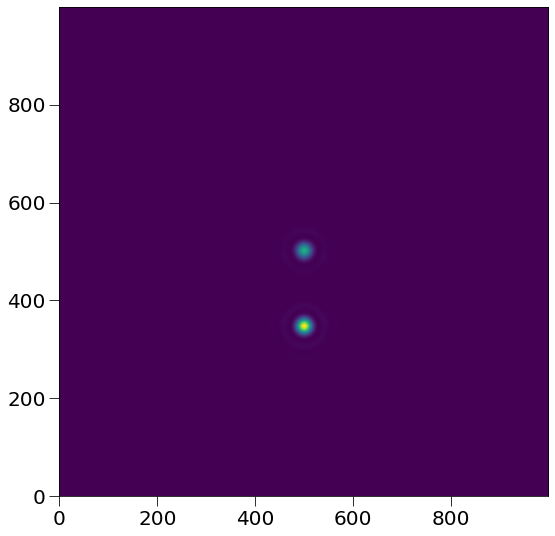

In [109]:
field_after_ss = plane_wave(1, np.array([xx,yy, 0]), k_star)*tA_complement
test_d_f = fresnel(xvals, yvals, field_after_ss)
field_free_prop = plane_wave(1, np.array([xx,yy, dist_ss_t]), k_star) +  plane_wave(1e-2, np.array([xx,yy, dist_ss_t]), k_exo)
f_t = (field_free_prop - test_d_f)*lens_transmit
fx, fy, image_field_compl_off = fraunhofer(xvals, yvals, f_t)
plt.figure(figsize=(9,9))
#norm=LogNorm(vmin=2.2e-3,vmax=2.4e5)
plt.imshow(np.abs(image_field_compl_off[500:1500, 500:1500])**2)


### Precomputing Fields

Two orthogonal objectives: 

 •Fast computation of a variety of input scenes
 
 •Fast computation with modified starshade shapes

For an input field consisting of $N \cdot N$ pixels, each pixel may be treated as a point source and propagated separately.

Between a variety of input fields the only difference for a fixed pixel point source is its amplitude $A$. Given a new field we may precompute the output fields for each pixel at location $[\xi, \eta]$, and find the total output field by summing the scaled fields together.

M.Hu points out that if a source is sufficiently off axis then the starshade tends to have negligible effect on the resultant field, they classify this as roughly ($>82 [mas]$ : $>20 [pixels]$ from center of haystacks model)

<font color='purple'> If true, this means we only need to store the propagated fields from roughly 1000 pixels (and propagate the rest past the telescope on the fly)</font>

Given $K$ wavelengths, this would require approximately $K \cdot 3 [gb]$ of storage space